# Load and visualize LSL data from Pico Neo 2 Eye 

## Load the data.

In [1]:
import numpy as np
import pyxdf

streams, header = pyxdf.load_xdf('test_pico_lsl.xdf')


for strm in streams:
    print(f"Found stream {strm['info']['name'][0]} ({strm['info']['type'][0]}) with data shape "
          f"{np.array(strm['time_series']).shape}")

stream_names = [strm['info']['name'][0] for strm in streams]
stream_types = [strm['info']['type'][0] for strm in streams]

Stream 1: Calculated effective sampling rate 71.7336 Hz is different from specified rate 20.0000 Hz.
Stream 2: Calculated effective sampling rate 71.7340 Hz is different from specified rate 20.0000 Hz.


Found stream Unity.GameEvents (Markers) with data shape (46, 1)
Found stream Unity.VRHeadPose (MoCap) with data shape (2192, 7)
Found stream Unity.TobiiGaze (Gaze) with data shape (2192, 12)


## Get the gaze focus events

(TODO: Show them on a plot)

In [2]:
import json


marker_ix = stream_types.index('Markers')
marker_tvec = streams[marker_ix]['time_stamps']
focus_dat = np.zeros((3, len(marker_tvec)), dtype=np.int)

for ix, ev in enumerate(streams[marker_ix]['time_series']):
    ev_info = json.loads(ev[0])['ObjectInfo']
    if ev_info['_hasFocus']:
        obj_id = int(ev_info['_identity'][-1])
        focus_dat[obj_id, ix] = 1

## Get the raw gaze data.

In [3]:
import matplotlib as mpl
mpl.rcParams['animation.convert_path'] = 'magick'
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

['Timestamp', 'ConvergenceDistance', 'ConvergenceDistanceIsValid', 'GazeRayOriginX', 'GazeRayOriginY', 'GazeRayOriginZ', 'GazeRayDirectionX', 'GazeRayDirectionY', 'GazeRayDirectionZ', 'GazeRayIsValid', 'IsLeftEyeBlinking', 'IsRightEyeBlinking']


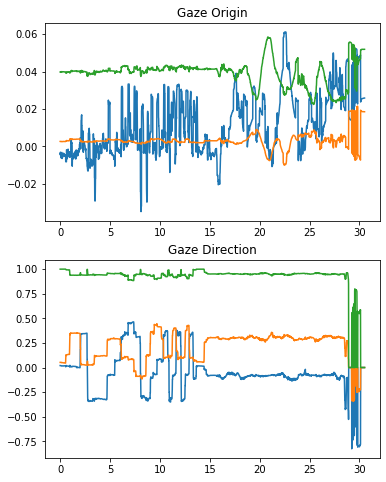

In [15]:
gaze_ix = stream_types.index('Gaze')
gaze_tvec = streams[gaze_ix]['time_stamps']

chan_labels = [_['label'][0] for _ in streams[gaze_ix]['info']['desc'][0]['channels'][0]['channel']]
print(chan_labels)

b_gaze_origin = [_.startswith('GazeRayOrigin') for _ in chan_labels]
gaze_origin_dat = streams[gaze_ix]['time_series'][:, b_gaze_origin]
b_gaze_dir = [_.startswith('GazeRayDirection') for _ in chan_labels]
gaze_dir_dat = streams[gaze_ix]['time_series'][:, b_gaze_dir]

b_valid = streams[gaze_ix]['time_series'][:, chan_labels.index('GazeRayIsValid')] > 0

plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(gaze_tvec[b_valid] - gaze_tvec[0], gaze_origin_dat[b_valid])
plt.title('Gaze Origin')
plt.subplot(2, 1, 2)
plt.plot(gaze_tvec[b_valid] - gaze_tvec[0], gaze_dir_dat[b_valid])
plt.title('Gaze Direction')
plt.show()

## Get the raw head pose data

['PosX', 'PosY', 'PosZ', 'RotW', 'RotX', 'RotY', 'RotZ']


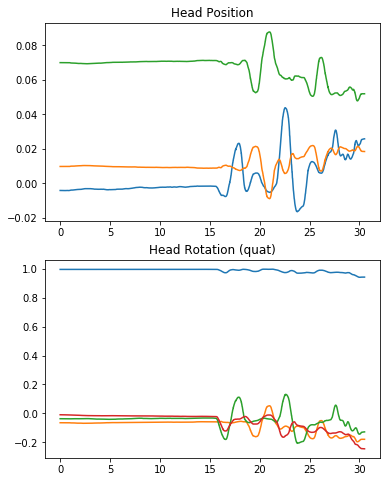

In [34]:
mocap_ix = stream_types.index('MoCap')
mocap_tvec = streams[mocap_ix]['time_stamps']

chan_labels = [_['label'][0] for _ in streams[mocap_ix]['info']['desc'][0]['channels'][0]['channel']]
print(chan_labels)

b_pos = [_.startswith('Pos') for _ in chan_labels]
pos_dat = streams[mocap_ix]['time_series'][:, b_pos]

b_rot = [_.startswith('Rot') for _ in chan_labels]
rot_dat = streams[mocap_ix]['time_series'][:, b_rot]

plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(mocap_tvec - mocap_tvec[0], pos_dat)
plt.title('Head Position')
plt.subplot(2, 1, 2)
plt.plot(mocap_tvec - mocap_tvec[0], rot_dat)
plt.title('Head Rotation (quat)')
plt.show()

## Plot head pose and gaze origin->direction in 3D plot.

Note that in these plots we swap the y- and z-data, simply because matplotlib makes it difficult to use arbitrary coordinate systems; +z is horizontal straight away from the face in Unity but vertical up in MPL.

In [21]:
from scipy.spatial.transform import Rotation as R


r = R.from_quat(np.roll(rot_dat, -1, axis=1))
head_dir = r.apply([0, 0, 1])
head_end = pos_dat + head_dir

gaze_3d = np.stack((gaze_origin_dat, gaze_dir_dat))

Text(0.5, 0.92, 'PicoNeo2Eye with LSL (blue=head, red=gaze)')

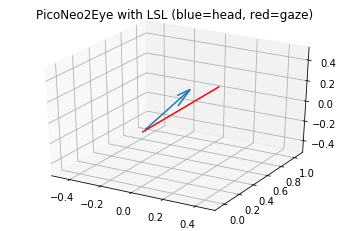

In [38]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.1, 1.1])
ax.set_zlim([-0.5, 0.5])
Q = ax.quiver3D(pos_dat[0, 0], pos_dat[0, 2], pos_dat[0, 1],
                head_end[0, 0], head_end[0, 2], head_end[0, 1],
                length=0.7, normalize=True)
L, = ax.plot(gaze_3d[:, 0, 0], gaze_3d[:, 0, 2], gaze_3d[:, 0, 1], 'r')
ax.set_title('PicoNeo2Eye with LSL (blue=head, red=gaze)')

In [39]:
step_interval = 1/60
mov_dur = 25
frames = int(mov_dur / step_interval)

def update(step):
    global Q
    Q.remove()
    
    head_ix = np.argmin(np.abs((mocap_tvec - mocap_tvec[0]) - step * step_interval))
    Q = ax.quiver3D(pos_dat[head_ix, 0], pos_dat[head_ix, 2], pos_dat[head_ix, 1],
                    head_end[head_ix, 0], head_end[head_ix, 2], head_end[head_ix, 1],
                    length=1.0, normalize=True)
    
    gaze_ix = np.argmin(np.abs(gaze_tvec - mocap_tvec[head_ix]))
    L.set_data(gaze_3d[:, gaze_ix, 0], gaze_3d[:, gaze_ix, 2])
    L.set_3d_properties(gaze_3d[:, gaze_ix, 1])
    

anim = FuncAnimation(fig, update, frames=np.arange(frames), interval=step_interval * 1000)
anim.save('piconeo2eye_lsl.mp4', dpi=80, writer='ffmpeg')
#import os
#os.system("ffmpeg -i C:\\my_path\\piconeo2eye_lsl.mp4 C:\\my_path\\piconeo2eye_lsl.gif")